# 모두의 주차장 앱 이용자 별 향후 이용 건수 예측

**3주차 과제 제출에 포함되어야 하는 형태 (최소)**
1. 모델링에 대한 결과 .ipynb 파일
2. np.random.seed(42) 설정
3. Input : X데이터 : [user_id, +@]
4. Output : Count column 예측값
5. 2020.01.01~2020.09.30 : Training Data
6. 2020.10.01~2020.12.31 : Test Data
7. 2020.10.01~2020.12.31 구간에 대한 MSE, MAE 계산값
8. 요일별 이용량에 대한 분석 - EDA
9. 유저별 이용 count 값에 대한 분석 - EDA

# 라이브러리

In [970]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [971]:
# 한글 출력을 위한 글꼴 설정
plt.rcParams['font.family'] = 'NanumGothic'
# 문자 - (마이너스) 정상 출력을 위한 코드
plt.rcParams['axes.unicode_minus'] = False    
# 소수점 둘 째 자리까지 표시
pd.options.display.float_format = '{:,.2f}'.format

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드

In [1050]:
df = pd.read_csv('실전db.csv', encoding='cp949')

In [1051]:
df.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [1052]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


> 결측치 없음 

## 데이터 설명

*	유저 가입 정보: id, 가입일
1. **USER_ID** : 유저 ID ; (정수형)
2. **JOIN_DATE** : 가입일 ; (문자형)    
*	소비 행동 정보: 상품id, 점포 주소, 결제일, 결제건수
3. **D_TYPE** : ?? ; (문자형)
4. **STORE_ID** : 점포 주소 ; (정수형)
5. **GOODS_TYPE** : 상품id ; (문자형)
6. **DATE** : 결제일 ; (문자형)
7. **COUNT** : 결제건수 ; (정수형)
8. **AD1** : ?? ; (문자형)
*	외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터

# 데이터 전처리

In [1053]:
# 시계열 데이터(JOIN_DATE, DATE)의 타입을 datetime으로 변환
df['JOIN_DATE']=pd.to_datetime(df['JOIN_DATE'],format='%Y-%m-%d')
df['DATE']=pd.to_datetime(df['DATE'],format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   USER_ID     879271 non-null  int64         
 1   JOIN_DATE   879271 non-null  datetime64[ns]
 2   D_TYPE      879271 non-null  object        
 3   STORE_ID    879271 non-null  int64         
 4   GOODS_TYPE  879271 non-null  object        
 5   DATE        879271 non-null  datetime64[ns]
 6   COUNT       879271 non-null  int64         
 7   AD1         879271 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 53.7+ MB


# EDA

## 컬럼 별 데이터 분포 확인

### USER_ID & COUNT

In [1054]:
# USER_ID 별 COUNT 건수 확인
userid_df=df.groupby('USER_ID')['COUNT'].sum().reset_index().sort_values('COUNT', ascending = False)
userid_df

,USER_ID,COUNT
44115,999665,7919
100781,1514190,284
16448,591610,245
90227,1467323,239
76230,1355841,235
...,...,...
45671,1023974,1
110166,1551355,1
45674,1024027,1
45676,1024047,1


> USER_ID가 999665인 유저의 결제건수가 7919건으로 다른 유저들에 비하여 유별나게 높음

In [1055]:
# 특이 고객으로 생각되는 999665 조회
df[df['USER_ID'] == 999665].sort_values('DATE')

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN
...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,CC,2428,A,2020-12-27,17,CY
868847,999665,2018-12-16,CC,109267,A,2020-12-28,24,J
871562,999665,2018-12-16,CC,90193,C,2020-12-29,23,GW
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS


> 하루도 빠짐없이 하루에 3건 이상씩 매일 이용한 것으로 미루어 볼 때 정상 고객 아이디는 아닐 것으로 추측하여 데이터에서 제외키로 결정

In [1056]:
# USER_ID 999665 데이터에서 드롭
df = df[df['USER_ID']!=999665]

### 고객 등급
* 고객별 결제 건수 합을 가지고 고객 등급을 나눌 수 있을 것

In [1057]:
# 유저ID별 결제 건수 합이 많은 순위
user_count_sum = df.groupby('USER_ID')['COUNT'].sum().reset_index().sort_values('COUNT', ascending = False)

In [1058]:
user_count_sum['COUNT']

100780    284
16448     245
90226     239
76229     235
62808     223
         ... 
81384       1
81383       1
81382       1
81379       1
165423      1
Name: COUNT, Length: 165424, dtype: int64

In [1059]:
# 처음 이용 고객(COUNT=1)
new_user = user_count_sum.loc[user_count_sum['COUNT']==1].count()
new_user

USER_ID    73947
COUNT      73947
dtype: int64

In [1060]:
# 실버고객(COUNT=2~4)
silver_user = user_count_sum.loc[user_count_sum['COUNT']>1]
silver_user.describe()

,USER_ID,COUNT
count,"91,477.00","91,477.00"
mean,"1,220,466.85",9.00
std,"432,264.28",15.13
min,224.00,2.00
25%,"904,038.00",2.00
50%,"1,343,644.00",4.00
75%,"1,571,650.00",9.00
max,"1,830,491.00",284.00


In [1061]:
# 골드고객(COUNT=5~18)
gold_user = user_count_sum.loc[user_count_sum['COUNT']>=5]
gold_user.describe()

,USER_ID,COUNT
count,"40,848.00","40,848.00"
mean,"1,202,381.47",16.86
std,"425,936.49",20.00
min,232.00,5.00
25%,"888,475.00",6.00
50%,"1,316,478.50",10.00
75%,"1,548,145.50",18.00
max,"1,826,434.00",284.00


In [1062]:
# VIP고객(COUNT=19~47)
vip_user = user_count_sum.loc[user_count_sum['COUNT']>=18]
vip_user.describe()

,USER_ID,COUNT
count,"10,761.00","10,761.00"
mean,"1,198,524.30",40.01
std,"410,432.47",27.54
min,232.00,18.00
25%,"902,985.00",22.00
50%,"1,314,648.00",30.00
75%,"1,527,789.00",47.00
max,"1,811,081.00",284.00


In [1063]:
# VVIP고객(COUNT=48~90)
vvip_user = user_count_sum.loc[user_count_sum['COUNT']>=48]
vvip_user.describe()

,USER_ID,COUNT
count,"2,604.00","2,604.00"
mean,"1,171,450.43",78.36
std,"397,790.29",31.44
min,"7,973.00",48.00
25%,"879,449.00",56.00
50%,"1,281,086.00",68.00
75%,"1,508,497.75",90.00
max,"1,739,610.00",284.00


In [1064]:
# MVP고객(COUNT=91~)
mvp_user = user_count_sum.loc[user_count_sum['COUNT']>=91]
mvp_user.describe()

,USER_ID,COUNT
count,650.00,650.00
mean,"1,127,518.80",122.88
std,"380,104.11",30.06
min,"30,882.00",91.00
25%,"849,133.25",99.00
50%,"1,211,496.50",115.00
75%,"1,482,751.75",137.75
max,"1,690,069.00",284.00


총 165,424 유저 중 
- new = 73947명
- silver = 50629명
- gold = 30087명
- vip = 8157명
- vvip = 1954명
- mvp = 650명

In [1065]:
# 고객 등급 컬럼 생성
grade_list = []

for c in user_count_sum['COUNT']:
    if c == 1:
        grade_list.append('new')
    elif 2 <= c < 5:
        grade_list.append('silver')
    elif 5 <= c < 19:
        grade_list.append('gold')
    elif 19 <= c < 48:
        grade_list.append('vip')
    elif 48 <= c < 91:
        grade_list.append('vvip')
    elif c >= 91:
        grade_list.append('mvp')
    else:
        print('not_our_customer')
        
user_count_sum['GRADE'] = grade_list

In [1066]:
user_count_sum.loc[user_count_sum['GRADE']=='vvip'].sort_values('COUNT',ascending=False)

,USER_ID,COUNT,GRADE
120712,1595426,90,vvip
93360,1482035,90,vvip
65688,1252947,90,vvip
68866,1286164,90,vvip
36074,885353,90,vvip
...,...,...,...
59372,1187346,48,vvip
17529,609920,48,vvip
42350,973844,48,vvip
121514,1598679,48,vvip


In [1067]:
user_count_sum = user_count_sum.rename({'COUNT':'COUNT_SUM'}, axis=1)
user_count_sum

,USER_ID,COUNT_SUM,GRADE
100780,1514190,284,mvp
16448,591610,245,mvp
90226,1467323,239,mvp
76229,1355841,235,mvp
62808,1224426,223,mvp
...,...,...,...
81384,1402020,1,new
81383,1402008,1,new
81382,1401999,1,new
81379,1401974,1,new


In [1100]:
# 주 데이터에 유저ID별_결제건수_합과 고객등급에 관한 컬럼 merge
df = pd.merge(df, user_count_sum, how='left', on='USER_ID')
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,DAY,MONTH,COUNT_SUM,GRADE
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,2,01,1,new
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,2,01,2,silver
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,2,01,3,silver
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,2,01,33,vip
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,2,01,3,silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,3,12,1,new
878901,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,3,12,1,new
878902,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,3,12,1,new
878903,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,3,12,1,new


### JOIN_DATE

<AxesSubplot:>

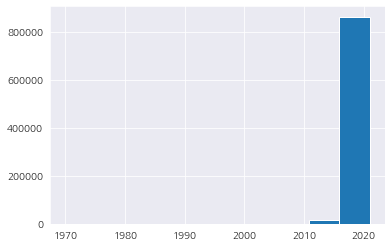

In [1069]:
# JOIN_DATE 데이터 분포 확인
df['JOIN_DATE'].hist()

> 1970년도까지 데이터가 분포되어 있어서 이상치가 있을 것으로 생각됨 

In [1070]:
# 이후 모델링에서 지정할 training data의 날짜보다 오래된 날짜의 데이터 선별
old_date_df = df[df['JOIN_DATE']<'2020-01-01']
# 동떨어져있는 가입날짜를 이상치로 전제하고 추려내기
error_date_df = old_date_df[old_date_df['JOIN_DATE']<'2013-12-16']
# 가입일이 정상인 데이터
normal_joindate_df = df[df['JOIN_DATE']>='2013-12-16']

In [1071]:
error_date_df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
437,1081430,1970-01-01,CC,90070,A,2020-01-01,1,GD
2196,1410151,1970-01-01,CC,92437,B,2020-01-02,1,J
2204,1415023,1970-01-01,CC,131081,A,2020-01-02,1,YO
2434,125582,1970-01-01,CC,91885,A,2020-01-03,1,YD
2645,602188,1970-01-01,CC,2334,B,2020-01-03,1,MP
...,...,...,...,...,...,...,...,...
866536,1723400,1970-01-01,CC,190188,A,2020-12-26,1,JR
867913,1723400,1970-01-01,CC,190188,A,2020-12-27,1,JR
868210,1825656,1970-01-01,CC,219936,A,2020-12-27,1,YD
873707,1828010,1970-01-01,CC,220635,C,2020-12-29,1,GN


In [1072]:
# 가입일 2013-12-16 이전의 데이터가 모두 1970-01-01 가입일의 데이터인지 확인
df_1970 = error_date_df[error_date_df['JOIN_DATE']=='1970-01-01']
df_1970

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
437,1081430,1970-01-01,CC,90070,A,2020-01-01,1,GD
2196,1410151,1970-01-01,CC,92437,B,2020-01-02,1,J
2204,1415023,1970-01-01,CC,131081,A,2020-01-02,1,YO
2434,125582,1970-01-01,CC,91885,A,2020-01-03,1,YD
2645,602188,1970-01-01,CC,2334,B,2020-01-03,1,MP
...,...,...,...,...,...,...,...,...
866536,1723400,1970-01-01,CC,190188,A,2020-12-26,1,JR
867913,1723400,1970-01-01,CC,190188,A,2020-12-27,1,JR
868210,1825656,1970-01-01,CC,219936,A,2020-12-27,1,YD
873707,1828010,1970-01-01,CC,220635,C,2020-12-29,1,GN


<AxesSubplot:>

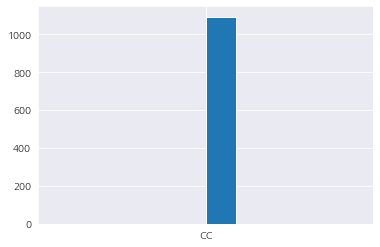

In [1073]:
df_1970['D_TYPE'].hist()

<AxesSubplot:>

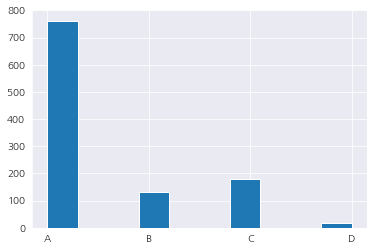

In [1074]:
df_1970['GOODS_TYPE'].hist()

<AxesSubplot:>

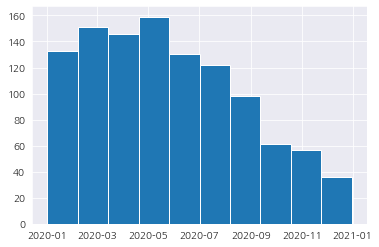

In [1075]:
df_1970['DATE'].hist()

> * 가입일이 1970-01-01인 데이터는 결제일이 2020년에 집계되지만 가입일을 알 수 없는 고객 데이터일 것으로 추정
> * 결제건수로 향후 이용 건수를 예측한다면 가입일 미상인 데이터도 활용할 수 있을 것
> * 즉, 이상치로 처리하지 않기로 판단

<AxesSubplot:>

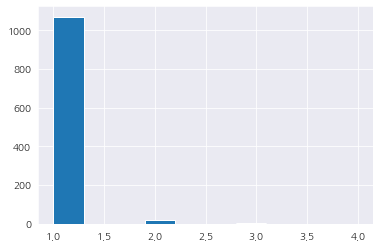

In [1076]:
df_1970['COUNT'].hist()

<AxesSubplot:>

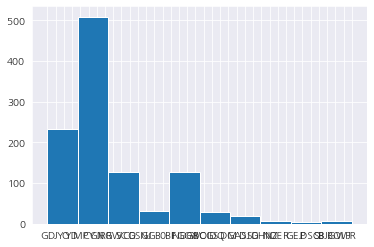

In [1077]:
df_1970['AD1'].hist()

### JOIN_DATE & COUNT

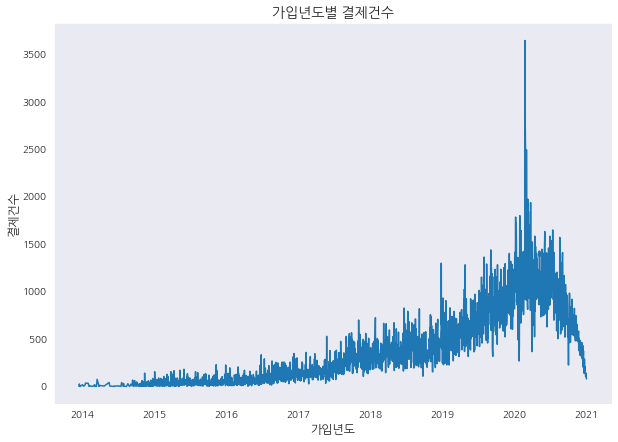

In [1078]:
# JOIN_DATE별 COUNT값(가입일 미상인 데이터는 제외)
plt.figure(figsize=(10,7))
sns.lineplot(normal_joindate_df.groupby("JOIN_DATE")["COUNT"].sum().keys(),normal_joindate_df.groupby("JOIN_DATE")["COUNT"].sum())
plt.title('가입년도별 결제건수', fontsize=14)
plt.ylabel('결제건수', fontsize=12)
plt.xlabel('가입년도', fontsize=12)
plt.grid()
plt.show()

> 가입년도가 2020년에 가까워질수록 결제건수의 합이 높아지다가 2020년 후반기로 가면서 점차 줄어들고 있다.
* 고객을 가입년도로 분류 가능할 것(ex. n년차 고객)

### JOIN_DATE & USER_ID

In [1079]:
# 가입년도 컬럼 생성
df['JOIN_YEAR'] = df['JOIN_DATE'].dt.year

In [1080]:
# 가입년도별 평균 결제건수
joinmean = df.groupby('JOIN_YEAR')['COUNT'].mean()
# 가입년도별 결제건수 합
joinsum = df.groupby('JOIN_YEAR')['COUNT'].sum()
display(joinmean, joinsum)

JOIN_YEAR
1970   1.02
2013   1.03
2014   1.02
2015   1.02
2016   1.02
2017   1.02
2018   1.02
2019   1.02
2020   1.02
Name: COUNT, dtype: float64

JOIN_YEAR
1970      1119
2013        38
2014      3003
2015     15284
2016     33295
2017     81356
2018    142791
2019    262493
2020    357541
Name: COUNT, dtype: int64

> 가입년도별 결제건수 평균이 매년 매우 유사한 것으로 미루어 볼 때, 가입년도 차이에 따른 각 년도별 평균 이용건수의 차이는 없다고 볼 수 있고, 대신 고객 수가 갈수록 많이 유입되어 년도별 결제 건수의 합은 우상향하는 것을 알 수 있다.

### D_TYPE

AA    493166
BB    384541
CC      1198
Name: D_TYPE, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


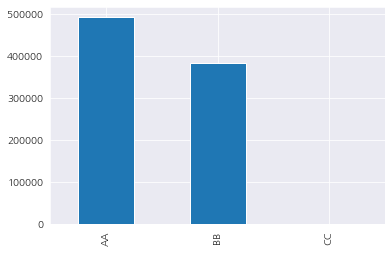

In [1082]:
#D_TYPE 컬럼 분포 확인
dtype_df=df['D_TYPE'].value_counts()
print(dtype_df)
print(dtype_df.plot.bar())

> D_TYPE CC가 1564개로, 그 개수가 나머지 AA와 BB에 비하여 눈에 띄게 적음

1093


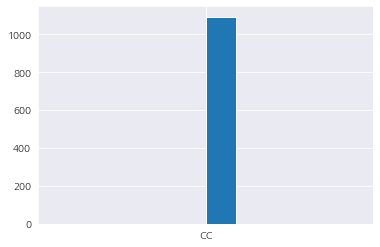

In [1083]:
# 위에서 가입일 미상인 고객 데이터의 D_TYPE이 전부 CC였던 것과의 연관성 살필 필요 있음
df_1970['D_TYPE'].hist()
print(df_1970['D_TYPE'].count())

> 가입일 미상인 고객 데이터가 D_TYPE이 CC인 전체 고객 데이터 중 1093/1564 = 69.88, **약 70% 차지**

In [1084]:
# USER_ID 하나당 D_TYPE이 한 개로 고정됨
df.groupby('USER_ID')['D_TYPE'].value_counts()

USER_ID  D_TYPE
224      AA         2
232      BB        23
342      AA         1
565      AA         2
729      AA         1
                   ..
1830551  BB         1
1830570  BB         1
1830580  AA         1
1830589  BB         1
1830598  AA         1
Name: D_TYPE, Length: 165424, dtype: int64

### STORE_ID

In [1086]:
df['STORE_ID'].unique()

array([  1892, 182009,  82431, ..., 231135, 231427, 231465], dtype=int64)

220557    17613
220893    17216
220655    16274
220848    15935
92437     15857
          ...  
231127        1
231128        1
225653        1
223093        1
225629        1
Name: STORE_ID, Length: 1060, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


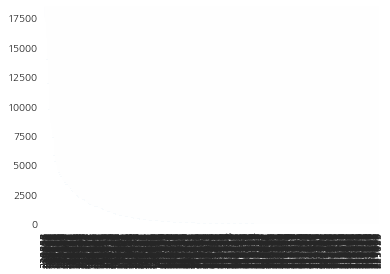

In [1087]:
#STORE_ID 컬럼 분포 확인
storeid_df=df['STORE_ID'].value_counts()
print(storeid_df)
print(storeid_df.plot.bar())

### STORE_ID & COUNT

In [1088]:
df.groupby('STORE_ID')['COUNT'].mean().reset_index().sort_values('COUNT', ascending = False)

,STORE_ID,COUNT
697,222268,1.67
737,222386,1.50
647,220978,1.50
735,222384,1.46
331,182781,1.33
...,...,...
624,220922,1.00
623,220921,1.00
621,220916,1.00
617,220908,1.00


> 점포주소별 평균 결제 건수에서 유의미한 차이 발견됨

### GOODS_TYPE
    주차권 종류: 평일 당일권 / 평일 심야권 / 휴일 당일권 / 시간권

A    609494
C    131108
B    118541
D     19762
Name: GOODS_TYPE, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


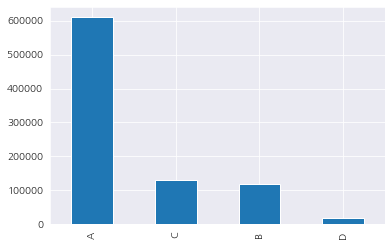

In [1089]:
#GOODS_TYPE 컬럼 분포 확인
gtype_df = df['GOODS_TYPE'].value_counts()
print(gtype_df)
print(gtype_df.plot.bar())

> 상품id가 A인 상품의 개수가 압도적으로 많고, D가 가장 적음

### GOODS_TYPE & COUNT

In [1090]:
df.groupby('GOODS_TYPE')['COUNT'].mean().reset_index().sort_values('COUNT', ascending = False)

,GOODS_TYPE,COUNT
2,C,1.03
3,D,1.02
0,A,1.02
1,B,1.01


> 상품별 평균 결제 건수에서 미세한 차이 있음

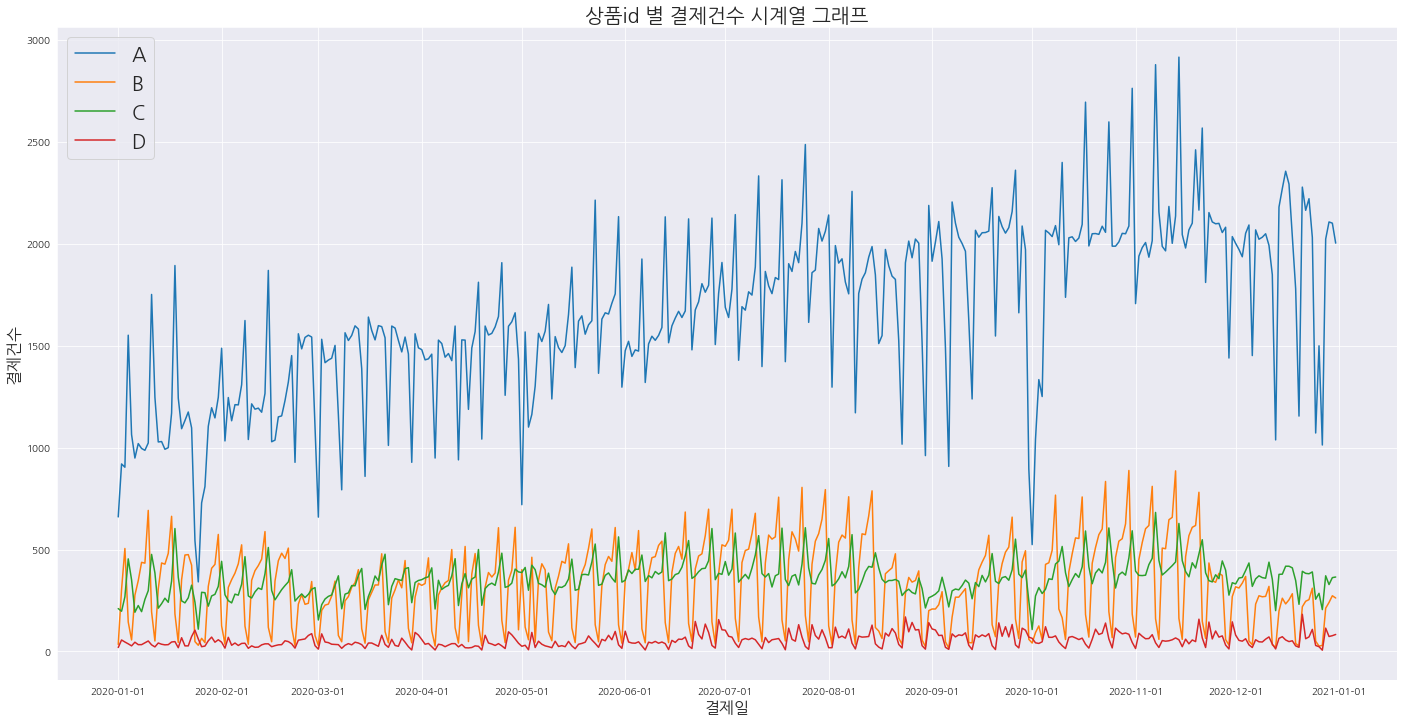

In [1091]:
# goods_type 별 결제건수 시각화
gtype_counts = df.groupby(['DATE', 'GOODS_TYPE']).size().unstack(fill_value=0)

plt.figure(figsize=(24,12))
sns.lineplot(gtype_counts.index, gtype_counts['A'])
sns.lineplot(gtype_counts.index, gtype_counts['B'])
sns.lineplot(gtype_counts.index, gtype_counts['C'])
sns.lineplot(gtype_counts.index, gtype_counts['D'])

plt.legend(['A', 'B', 'C', 'D'], loc='upper left', fontsize=20)
plt.title('상품id 별 결제건수 시계열 그래프', fontsize=20)
plt.ylabel('결제건수', fontsize=16)
plt.xlabel('결제일', fontsize=16)
plt.xticks(ticks = ['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01'])
plt.show()

### 요일별 이용량 분석

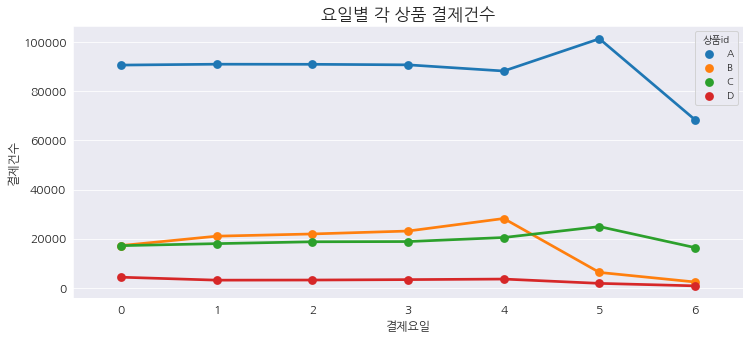

In [1092]:
df['DAY'] = df['DATE'].dt.weekday
counts_days = df.groupby(['DAY','GOODS_TYPE'])['COUNT'].sum().reset_index()
counts_days_df = counts_days[['DAY','GOODS_TYPE','COUNT']]
counts_days_df.columns = ['결제요일','상품id','결제건수']

fig, ax = plt.subplots(1,1, figsize = (12,5))
sns.pointplot(x = '결제요일', y = '결제건수', hue = '상품id', data = counts_days_df)
plt.title('요일별 각 상품 결제건수', fontsize = 17)
plt.xlabel('결제요일', fontsize = 12)
plt.ylabel('결제건수', fontsize = 12)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)
plt.show()

1. A의 결제건수가 가장 많으므로 시간권으로 예상할 수 있다.
2. B의 결제건수가 주말이 되면 크게 줄어들기 때문에 평일 당일권임을 추측할 수 있다.
3. C의 결제건수는 주말이 되면 오히려 증가하므로 휴일 당일권일 것으로 추측했다.
4. D의 결제건수는 가장 적고 주말에 감소하는 경향이 있어서 평일 심야권일 것으로 생각했다.

### DATE & COUNT

In [1093]:
# 결제월 별 결제건수 분포를 깔끔하게 시각화하기 위해서 월 컬럼 생성
df.DATE = pd.to_datetime(df.DATE)
df["MONTH"] = df.DATE.dt.strftime('%m')

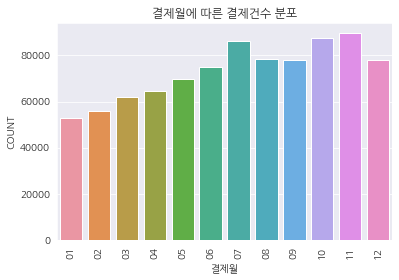

In [1094]:
# 결제월에 따른 결제건수 분포 확인
sns.countplot(x=df['MONTH'],data=df)
plt.xticks(rotation=90)
plt.xlabel('결제월')
plt.ylabel('COUNT')
plt.title('결제월에 따른 결제건수 분포', fontsize=12)
plt.show()

### AD1

In [1095]:
df['AD1'].unique()

array(['GN', 'J', 'SC', 'MP', 'JRR', 'YD', 'GJ', 'YO', 'GSN', 'GBC', 'BF',
       'DJ', '0', 'CD', 'NO', 'CY', 'YC', 'SD', 'GD', 'GSW', 'DM', 'R',
       'GB', 'GS', 'GHN', 'SB', 'IND', 'P', 'GW', 'JR', 'GEJ', 'GGY',
       'GKP', 'CAS', 'SG', 'BJG', 'BHW', 'GAY', 'GYI', 'CCA', 'PJP',
       'GGC', 'IYS', 'DB', 'GGM', 'GAS', 'WOID', 'DIV', 'AOI', 'COI',
       'GPJ', 'SOI', 'ABP', 'DOI', 'WF', 'BI', 'ZP', 'EP', 'Q', 'BO',
       'ZE', 'RRR', 'QGI', 'DSO', 'SOD', 'BOI', 'WT', 'BP', 'SP', 'CN',
       'SJV', 'SDU', 'QH', 'BUD', 'CU', 'VU', 'WAE', 'NW', 'WH', 'GR',
       'X', 'CVB', 'ADS', 'VO'], dtype=object)

In [1096]:
# AD1='0'인 데이터가 유일하게 숫자로 된 문자형이라서 이상치인지 확인 
df[df['AD1']=='0']

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,DAY,MONTH
87,459009,2017-02-04,AA,220296,C,2020-01-01,1,0,2017,2,01
373,999827,2018-12-17,AA,220296,C,2020-01-01,1,0,2018,2,01
778,1431463,2019-12-15,AA,220296,C,2020-01-01,1,0,2019,2,01
885,1454563,2020-01-01,AA,220296,C,2020-01-01,1,0,2020,2,01
908,1454716,2020-01-01,AA,220296,C,2020-01-01,1,0,2020,2,01
...,...,...,...,...,...,...,...,...,...,...,...
868163,1820061,2020-12-21,AA,204840,A,2020-12-27,1,0,2020,6,12
868604,734682,2018-02-24,BB,172827,A,2020-12-28,1,0,2018,0,12
868622,752024,2018-03-15,AA,204453,A,2020-12-28,1,0,2018,0,12
870109,1658882,2020-08-16,BB,172827,B,2020-12-28,1,0,2020,0,12


> 문제 없어 보임

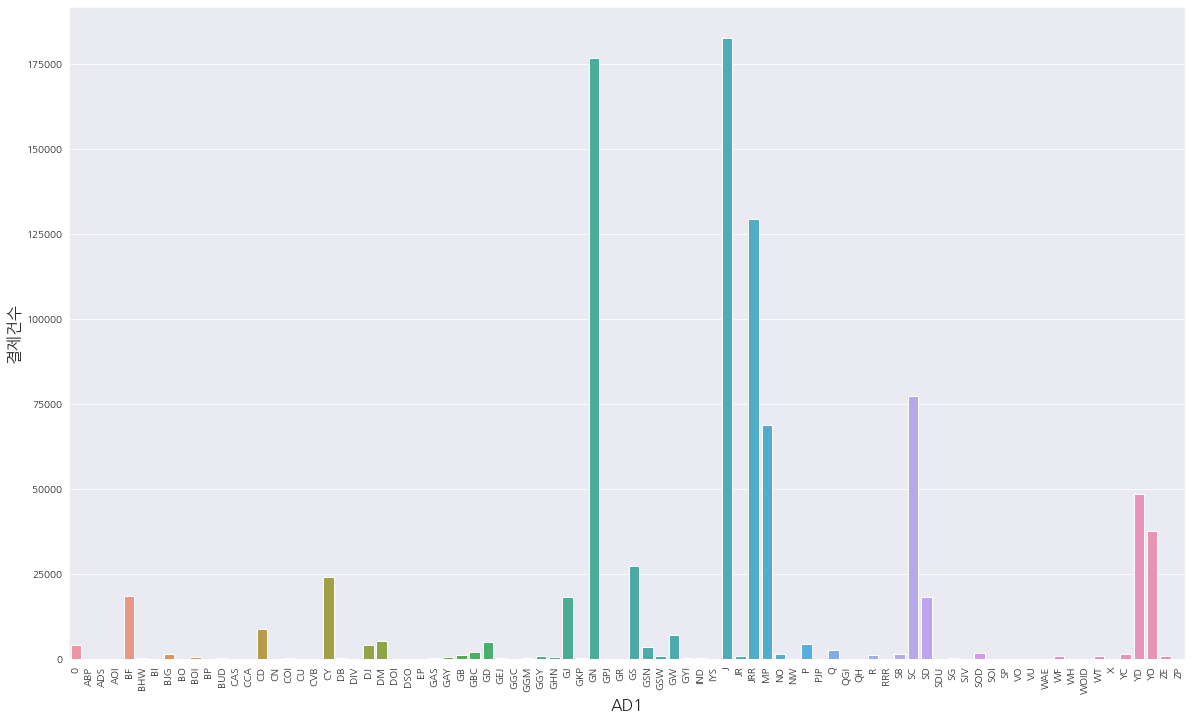

J      179291
GN     172906
JRR    126538
SC      75810
MP      67803
YD      47673
YO      37156
GS      26857
CY      23364
BF      18030
GJ      17935
SD      17763
CD       8534
GW       7040
DM       5126
GD       4988
P        4345
0        4225
Name: AD1, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


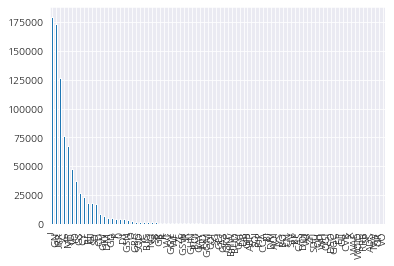

In [1097]:
# AD1별 결제건수 시각화
plt.figure(figsize=(20,12))
sns.barplot(x=df.groupby("AD1")["COUNT"].sum().keys(), y=df.groupby("AD1")["COUNT"].sum())
plt.ylabel('결제건수', fontsize=16)
plt.xlabel('AD1', fontsize=16)
plt.xticks(rotation='vertical')
plt.show()

#AD1 컬럼 분포 확인
ad1_df=df['AD1'].value_counts()
print(ad1_df.head(18))
print(ad1_df.plot.bar())

> * STORE_ID의 plot과 비슷한 형태인 것으로 파악됨
> * AD1과 STORE_ID와의 연관성 파악할 필요성 느낌

### STORE_ID의 관계를 통해 AD1 유추

In [1098]:
ad1store = df.groupby(['AD1','STORE_ID'])['COUNT'].sum()
ad1store_df = ad1store.to_frame()
ad1store_df.sort_values(['AD1','COUNT'])

COUNT
AD1 STORE_ID       
0   219885        1
    223008        3
    203790        7
    223082       21
    190306       22
...             ...
ZE  222384       60
    222352      145
    219891      652
ZP  221040        7
    220973       23

[1060 rows x 1 columns]

> 점포 주소인 STORE_ID가 AD1 항목에 중복없이 묶인 것으로 볼 때, AD1은 일종의 Address일 것으로 추측

### 외부 데이터 합치기 전 내부 데이터

In [1101]:
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,DAY,MONTH,COUNT_SUM,GRADE
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,2,01,1,new
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,2,01,2,silver
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,2,01,3,silver
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,2,01,33,vip
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,2,01,3,silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,3,12,1,new
878901,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,3,12,1,new
878902,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,3,12,1,new
878903,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,3,12,1,new


## 외부 데이터

### 기상 데이터

In [1102]:
w_df = pd.read_csv('서울시_기상데이터.csv', encoding='cp949')

In [1103]:
w_df

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.90,nan,1.70,40,nan,nan,-2.40,3.20
1,108,2020-01-01 2:00,-5.70,nan,0.10,42,nan,nan,-2.40,3.10
2,108,2020-01-01 3:00,-5.60,0.00,0.00,46,nan,nan,-2.70,3.10
3,108,2020-01-01 4:00,-5.40,nan,0.00,50,nan,nan,-2.50,3.00
4,108,2020-01-01 5:00,-5.20,nan,0.00,55,nan,nan,-2.20,3.00
...,...,...,...,...,...,...,...,...,...,...
8755,108,2020-12-30 20:00,-11.80,nan,4.80,54,nan,nan,-6.50,2.20
8756,108,2020-12-30 21:00,-12.40,nan,3.20,58,nan,nan,-6.90,2.20
8757,108,2020-12-30 22:00,-12.70,nan,2.80,56,nan,nan,-7.10,2.10
8758,108,2020-12-30 23:00,-12.90,nan,2.20,54,nan,nan,-7.30,2.10


In [1104]:
w_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   지점      8760 non-null   int64  
 1   일시      8760 non-null   object 
 2   기온      8759 non-null   float64
 3   강수량     1059 non-null   float64
 4   풍속      8760 non-null   float64
 5   습도      8760 non-null   int64  
 6   일조시간    4791 non-null   float64
 7   적설량     208 non-null    float64
 8   지면온도    8752 non-null   float64
 9   지중온도    8748 non-null   float64
dtypes: float64(7), int64(2), object(1)
memory usage: 684.5+ KB


In [1105]:
# 일시 컬럼을 날짜와 시간으로 분리 
w_df['날짜']=0
for i in range(len(w_df)):
    w_df['날짜'][i] = w_df['일시'].iloc[i][:10]
    w_df['시간'] = 0
for i in range(len(w_df)):
    w_df['시간'][i] = w_df['일시'].iloc[i][11:]

In [1106]:
# datetime 타입으로 변환
w_df['날짜'] = w_df['날짜'].astype('datetime64')

In [1107]:
# NaN값 개수
w_df.isnull().sum()

지점         0
일시         0
기온         1
강수량     7701
풍속         0
습도         0
일조시간    3969
적설량     8552
지면온도       8
지중온도      12
날짜         0
시간         0
dtype: int64

In [1108]:
# 기온에 결측값이 포함된 전체 행 추출
w_df.loc[w_df['기온'].isnull()]

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,날짜,시간
5724,108,2020-08-26 13:00,nan,nan,4.30,60,0.60,nan,35.90,27.50,2020-08-26,13:00


In [1109]:
# 결측값 전후 기온을 확인하여 평균값으로 결측치 대체
w_df.loc[w_df['날짜']=='2020-08-26']

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,날짜,시간
5711,108,2020-08-26 0:00,28.70,nan,2.70,76,nan,nan,27.10,27.90,2020-08-26,0:00
5712,108,2020-08-26 1:00,28.40,nan,2.10,77,nan,nan,26.60,27.90,2020-08-26,1:00
5713,108,2020-08-26 2:00,28.10,nan,1.80,79,nan,nan,26.10,27.80,2020-08-26,2:00
5714,108,2020-08-26 3:00,27.60,nan,2.00,80,nan,nan,25.80,27.80,2020-08-26,3:00
5715,108,2020-08-26 4:00,27.30,nan,2.00,82,nan,nan,25.60,27.80,2020-08-26,4:00
5716,108,2020-08-26 5:00,27.20,nan,2.10,82,nan,nan,25.40,27.80,2020-08-26,5:00
5717,108,2020-08-26 6:00,27.00,nan,2.90,82,0.00,nan,25.30,27.70,2020-08-26,6:00
5718,108,2020-08-26 7:00,27.30,nan,2.70,82,0.60,nan,25.80,27.70,2020-08-26,7:00
5719,108,2020-08-26 8:00,28.60,nan,2.70,79,1.00,nan,28.10,27.60,2020-08-26,8:00
5720,108,2020-08-26 9:00,29.70,nan,3.20,74,0.80,nan,31.20,27.60,2020-08-26,9:00


In [1110]:
# 08-26 12:00와 14:00 기온의 평균 구하기
(33.30+34.10)/2

33.7

In [1111]:
# 33.70으로 결측치 대체 후 null값 제대로 채워졌는지 확인
w_df['기온'] = w_df['기온'].fillna(33.70)
w_df.isnull().sum()

지점         0
일시         0
기온         0
강수량     7701
풍속         0
습도         0
일조시간    3969
적설량     8552
지면온도       8
지중온도      12
날짜         0
시간         0
dtype: int64

In [1112]:
# 12월 31일 날씨 데이터가 0:00시 밖에 없음 => 누락된 데이터 당일 최고기온으로 수정
w_df.loc[w_df['날짜']=='2020-12-31', '기온'] = -5.00
w_df = w_df[['날짜','기온','습도','강수량','적설량']]
w_df

,날짜,기온,습도,강수량,적설량
0,2020-01-01,-5.90,40,nan,nan
1,2020-01-01,-5.70,42,nan,nan
2,2020-01-01,-5.60,46,0.00,nan
3,2020-01-01,-5.40,50,nan,nan
4,2020-01-01,-5.20,55,nan,nan
...,...,...,...,...,...
8755,2020-12-30,-11.80,54,nan,nan
8756,2020-12-30,-12.40,58,nan,nan
8757,2020-12-30,-12.70,56,nan,nan
8758,2020-12-30,-12.90,54,nan,nan


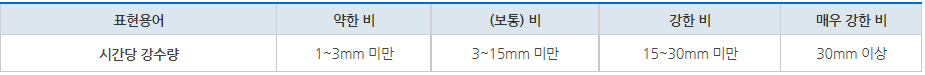

In [1113]:
# 최고기온
max_temp_df = w_df.groupby('날짜')['기온'].max().reset_index().rename(columns={'기온':'최고기온'}, inplace=False)

# 일 평균 시간당 강수량
rain_day_df = w_df.groupby('날짜')['강수량'].mean().reset_index().rename(columns={'강수량':'일 평균 시간당 강수량'}, inplace=False)

# 최고습도
humidity_df = w_df.groupby('날짜')['습도'].max().reset_index().rename(columns={'습도':'최고습도'}, inplace=False)

# Merge
dailyweather_df = pd.merge(max_temp_df, rain_day_df, how='outer', on='날짜')
dailyweather_df2 = pd.merge(dailyweather_df, humidity_df, how='outer', on='날짜')

In [1114]:
dailyweather_df2

,날짜,최고기온,일 평균 시간당 강수량,최고습도
0,2020-01-01,0.30,0.03,76
1,2020-01-02,3.80,nan,74
2,2020-01-03,4.30,nan,86
3,2020-01-04,6.10,nan,64
4,2020-01-05,6.50,nan,61
...,...,...,...,...
361,2020-12-27,9.90,0.00,77
362,2020-12-28,11.00,0.65,91
363,2020-12-29,4.20,0.07,85
364,2020-12-30,-6.20,nan,63


In [1115]:
dailyweather_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   날짜            366 non-null    datetime64[ns]
 1   최고기온          366 non-null    float64       
 2   일 평균 시간당 강수량  149 non-null    float64       
 3   최고습도          366 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 14.3 KB


### 교통량 데이터

In [1116]:
t_df = pd.read_excel('2020교통량통합.xlsx')

In [1117]:
t_df.head(1)

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.00,645.00,437.00,309.00,290.00,...,"1,472.00","1,416.00","1,483.00","1,329.00","1,157.00","1,014.00",954.00,849.00,780.00,480.00


In [1118]:
# 일 평균 교통량
t_df['일 평균 교통량'] = t_df.loc[:,'0시':'23시'].mean(axis = 1)
mean_traffic = t_df.groupby('DATE')['일 평균 교통량'].mean().reset_index().rename(columns = {'DATE' : '날짜'})
mean_traffic

,날짜,일 평균 교통량
0,2020-01-01,"1,190.90"
1,2020-01-02,"1,512.71"
2,2020-01-03,"1,608.53"
3,2020-01-04,"1,476.21"
4,2020-01-05,"1,260.95"
...,...,...
361,2020-12-27,999.32
362,2020-12-28,"1,484.32"
363,2020-12-29,"1,495.89"
364,2020-12-30,"1,480.77"


In [1119]:
mean_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   날짜        366 non-null    datetime64[ns]
 1   일 평균 교통량  366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [1120]:
ex_df = pd.merge(dailyweather_df2, mean_traffic, how = 'outer', on='날짜')
ex_df

,날짜,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량
0,2020-01-01,0.30,0.03,76,"1,190.90"
1,2020-01-02,3.80,nan,74,"1,512.71"
2,2020-01-03,4.30,nan,86,"1,608.53"
3,2020-01-04,6.10,nan,64,"1,476.21"
4,2020-01-05,6.50,nan,61,"1,260.95"
...,...,...,...,...,...
361,2020-12-27,9.90,0.00,77,999.32
362,2020-12-28,11.00,0.65,91,"1,484.32"
363,2020-12-29,4.20,0.07,85,"1,495.89"
364,2020-12-30,-6.20,nan,63,"1,480.77"


In [1121]:
# 내부데이터
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,DAY,MONTH,COUNT_SUM,GRADE
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,2,01,1,new
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,2,01,2,silver
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,2,01,3,silver
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,2,01,33,vip
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,2,01,3,silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,3,12,1,new
878901,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,3,12,1,new
878902,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,3,12,1,new
878903,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,3,12,1,new


In [1122]:
core_df = df[['DATE','USER_ID','GRADE','AD1','STORE_ID','GOODS_TYPE','COUNT','COUNT_SUM']]
core_df = core_df.rename(columns={'DATE':'날짜'})

In [1123]:
data = pd.merge(core_df, ex_df, how = 'outer', on='날짜')
data = data.sort_values(['COUNT'], ascending=False)
data = data.fillna(0)
data = data[['날짜','USER_ID','GRADE', 'AD1','STORE_ID', 'GOODS_TYPE', '최고기온','일 평균 시간당 강수량', '최고습도', '일 평균 교통량','COUNT_SUM', 'COUNT']]

## 유저별 이용 COUNT값 분석

# 모델링

In [1124]:
# 예측모델 관련 라이브러리 import
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf

## 데이터 전처리

### AD1에서 서울 자치구만 추려내기

In [1125]:
data['AD1'].unique()

array(['JRR', 'GN', 'J', 'SC', 'CY', 'SB', 'MP', 'SD', 'YD', 'YO', 'BF',
       'DJ', 'GGY', 'SJV', 'GW', 'GS', 'Q', 'BOI', 'SOD', 'ZE', 'GJ',
       'GSN', 'GD', 'YC', 'DM', 'GAY', 'CD', 'P', 'NO', 'GB', 'GBC', '0',
       'JR', 'GYI', 'IYS', 'GAS', 'BJG', 'GSW', 'R', 'IND', 'GPJ', 'GHN',
       'BP', 'WT', 'WF', 'CCA', 'BHW', 'BI', 'ABP', 'GGM', 'PJP', 'SG',
       'BO', 'DB', 'GKP', 'CU', 'GEJ', 'CN', 'BUD', 'COI', 'RRR', 'CAS',
       'QH', 'WAE', 'AOI', 'DIV', 'VU', 'DSO', 'SOI', 'NW', 'EP', 'SDU',
       'GGC', 'QGI', 'DOI', 'SP', 'ZP', 'CVB', 'X', 'WH', 'VO', 'ADS',
       'GR', 'WOID'], dtype=object)

***서울 지역구***
1. 종로구 : JR

2. 중구 : J

3. 용산구 : YO

4. 성동구 : SOD

5. 광진구 : GJ

6. 동대문구 : DM

7. 중랑구 : JRR

8. 성북구 : SB

9. 강북구 : GB

10. 도봉구 : DB

11. 노원구 : NW

12. 은평구 : EP

13. 서대문구 : SD

14. 마포구 : MP

15. 양천구 : YC

16. 강서구 : GS

17. 구로구 : GR

18. 금천구 : GHN

19. 영등포구 : YD

20. 동작구 : DJ

21. 관악구 : GW

22. 서초구 : SC

23. 강남구 : GN

24. 송파구 : SP

25. 강동구 : GD

In [711]:
seoul = ['JR','J','YO','SOD','GJ','DM','JRR','SB','GB','DB','NW','EP','SD','MP','YC','GS','GR','GHN','YD','DJ','GW','SC','GN','SP','GD']

In [1126]:
seoul_list = []

for g in data['AD1']:
    if g in seoul:
        seoul_list.append('SEOUL')
    else:
        seoul_list.append('!SEOUL')

data['SEOUL'] = seoul_list

In [1127]:
notseoul = data.loc[data['SEOUL']=='!SEOUL']
notseoul

,날짜,USER_ID,GRADE,AD1,STORE_ID,GOODS_TYPE,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,COUNT_SUM,COUNT,SEOUL
618621,2020-09-28,1675314,vip,CY,109670,A,26.30,0.00,86,"1,602.54",27,15,!SEOUL
617911,2020-09-28,1552636,mvp,CY,82433,A,26.30,0.00,86,"1,602.54",146,7,!SEOUL
631826,2020-10-05,1715361,gold,BF,222258,B,18.30,0.00,74,"1,540.30",7,7,!SEOUL
633674,2020-10-06,1552636,mvp,CY,82433,B,19.30,0.00,82,"1,597.20",146,6,!SEOUL
64649,2020-02-07,992712,vvip,GGY,105156,C,1.70,0.00,70,"1,594.78",51,6,!SEOUL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295312,2020-05-27,1577492,gold,BF,2364,B,23.50,0.00,93,"1,610.17",9,1,!SEOUL
295319,2020-05-27,1577880,vip,CY,220764,A,23.50,0.00,93,"1,610.17",25,1,!SEOUL
295296,2020-05-27,1575398,gold,CD,48177,A,23.50,0.00,93,"1,610.17",5,1,!SEOUL
295272,2020-05-27,1573594,gold,NO,105202,A,23.50,0.00,93,"1,610.17",13,1,!SEOUL


In [1128]:
data = data.loc[data['SEOUL']=='SEOUL']
data

,날짜,USER_ID,GRADE,AD1,STORE_ID,GOODS_TYPE,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,COUNT_SUM,COUNT,SEOUL
419395,2020-07-15,1467323,mvp,JRR,220836,B,28.60,0.00,77,"1,612.17",239,23,SEOUL
476678,2020-08-04,1635143,vip,GN,221045,A,29.30,0.26,98,"1,465.51",23,23,SEOUL
371937,2020-06-27,1467323,mvp,JRR,220836,A,29.40,0.00,82,"1,556.58",239,22,SEOUL
31907,2020-01-18,1467323,mvp,JRR,220836,A,5.70,0.00,68,"1,559.07",239,20,SEOUL
208324,2020-04-18,1544719,vip,GN,221045,A,19.40,0.00,93,"1,434.18",19,19,SEOUL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295290,2020-05-27,1575085,vip,MP,109160,A,23.50,0.00,93,"1,610.17",36,1,SEOUL
295291,2020-05-27,1575113,mvp,GJ,109557,A,23.50,0.00,93,"1,610.17",99,1,SEOUL
295292,2020-05-27,1575117,silver,JRR,220966,A,23.50,0.00,93,"1,610.17",4,1,SEOUL
295293,2020-05-27,1575262,gold,GN,104988,A,23.50,0.00,93,"1,610.17",5,1,SEOUL
